# 4. BLIP 

In [8]:
import os
import sys
import pickle
import json
import glob
import gc
import random
import time
import unicodedata
import traceback
import datetime
import copy

import numpy as np
import pandas as pd

from pathlib import Path
import matplotlib.pyplot as plt
import torch
from PIL import Image
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

import torch
import torchvision
from torchvision.models import (
    vit_b_16, ViT_B_16_Weights, 
    vit_l_16, ViT_L_16_Weights,
    vit_h_14, ViT_H_14_Weights,
    regnet_y_32gf, RegNet_Y_32GF_Weights,
    regnet_y_128gf, RegNet_Y_128GF_Weights,
    regnet_y_16gf, RegNet_Y_16GF_Weights,
    efficientnet_v2_l, EfficientNet_V2_L_Weights
)
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import (
    StepLR, MultiStepLR, 
    ConstantLR, LinearLR, 
    ExponentialLR, PolynomialLR, 
    CosineAnnealingLR, CosineAnnealingWarmRestarts, 
    CyclicLR, OneCycleLR, 
    ReduceLROnPlateau
)

sys.path.append('../input/sentence-transformers-222/sentence-transformers')
from sentence_transformers import SentenceTransformer, models

os.environ["TOKENIZERS_PARALLELISM"] = "false"

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
from transformers import AutoProcessor, BlipForConditionalGeneration

from scipy.spatial import distance

In [2]:
class CFG:
    seed = 42
    text_emb_size = 384
    is_kaggle = (os.environ.get('PWD') == '/kaggle/working')
    
    train_files_dir = "img2prompt-data"    

    # DATASET FILTERS
    img_size_min = 512
    img_size_max = 512
    img_max_ratio_diff = 1
    prompt_words_min = 5
    prompt_words_max = 100
    prompt_is_english = True
    drop_duplicates_by_head = True
    drop_duplicates_by_tail = True
    drop_duplicates_char_len = 10
    
    img_dataset_name = f"img_{img_size_min}_{img_size_max}_ratio_{img_max_ratio_diff}"
    prompt_dataset_name = f"prompt_{prompt_words_min}_{prompt_words_max}_dupl_{drop_duplicates_char_len}"
    dataset_name = f"{img_dataset_name}_{prompt_dataset_name}"
    
    # TRAIN TEST SPLIT
    test_size = 0.02
    
    # MODEL
    model = "blip_large" # "blip_base", "blip_large"
    max_length=100
    min_length=5
    num_return_sequences=5
    num_beams=5
    repetition_penalty=10.0
    model_name = f"model_{model}_len_{min_length}_{max_length}_seq_{num_return_sequences}_beams_{num_beams}_reppen_{str(repetition_penalty).replace('.', '_')}"
    
    # RESOURCES
    batch_size = 16
    num_workers = batch_size if not is_kaggle else 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_name = model_name
    

set_seed(CFG.seed)
CFG.train_name

'model_blip_large_len_5_100_seq_5_beams_5_reppen_10_0'

## Val functions

In [3]:
def get_model(model_name):
    if model_name == "blip_base":
        if CFG.is_kaggle:
            hf_model_name = f"../input/img2prompt-data/blip-image-captioning-base/"
        else:
            hf_model_name = "Salesforce/blip-image-captioning-base"
    elif model_name == "blip_large":
        if CFG.is_kaggle:
            hf_model_name = f"../input/img2prompt-data/blip-image-captioning-large/"
        else:
            hf_model_name = "Salesforce/blip-image-captioning-large"
    processor = AutoProcessor.from_pretrained(hf_model_name)
    model = BlipForConditionalGeneration.from_pretrained(hf_model_name) 
    model.to(CFG.device)
    return model, processor

class CustomDataSet(Dataset):
    def __init__(self, data_dir, img2prompt):
        self.data_dir = data_dir
        self.img_names = list(img2prompt.keys())
        self.img2prompt = img2prompt
        
        self.preprocess = transforms.Compose([
            transforms.Resize(512, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        img_tensor = self.preprocess(img)
        
        prompt = self.img2prompt[img_name]
        
        return img_name, img_tensor, prompt

def create_submission(pred_arr, img_names):
    imgIds = [i.split('.')[0] for i in img_names]

    EMBEDDING_LENGTH = CFG.text_emb_size
    eIds = list(range(EMBEDDING_LENGTH))

    imgId_eId = [
        '_'.join(map(str, i)) for i in zip(
            np.repeat(imgIds, EMBEDDING_LENGTH),
            np.tile(range(EMBEDDING_LENGTH), len(imgIds)))]
    
    submission = pd.DataFrame(
                    index=imgId_eId,
                    data=np.array(pred_arr).flatten(),
                    columns=['val']).rename_axis('imgId_eId')
    return submission

## Train functions 

In [4]:
def get_sim(emb1, emb2):
    assert len(emb1.shape) <= 2 and len(emb1.shape) <= 2, "False shape"
    
    if len(emb1.shape) == 1:
        emb1 = [emb1]
    if len(emb2.shape) == 1:
        emb2 = [emb2]
    
    sim_res = 0
    for i in range(len(emb1)):
        sim_res += 1 - distance.cosine(emb1[i], emb2[i])
    return sim_res / (i + 1)

def filter_metadata(df, 
                    img_size_min, img_size_max, 
                    img_max_ratio_diff, 
                    prompt_words_min, prompt_words_max, 
                    prompt_is_english,
                    drop_duplicates_by_head, 
                    drop_duplicates_by_tail, 
                    drop_duplicates_char_len):
    def is_english_only(string):
        for s in string:
            cat = unicodedata.category(s)         
            if (cat not in ['Ll', 'Lu', 'Nd', 'Po', 'Pd', 'Zs']) or (not cat.isascii()):
                return False
        
        return True
    
    df = df.copy()
    
    df["size_ratio"] = df["height"] / df["width"]
    df['prompt'] = df['prompt'].str.strip()
    df["num_words"] = df['prompt'].str.split(" ").apply(len)
    df["is_english"] = df["prompt"].apply(is_english_only)
    
    img_hw_cond = (
        df["width"].between(img_size_min, img_size_max) & 
        df["height"].between(img_size_min, img_size_max)
    )
    img_ratio_cond = df["size_ratio"].between(1/img_max_ratio_diff, img_max_ratio_diff)
    prompt_empty_cond = (df["prompt"] != "")
    prompt_num_words_cond = df["num_words"].between(prompt_words_min, prompt_words_max)

    if prompt_is_english:
        df = df[df["is_english"]]
    
    if drop_duplicates_by_head:
        df['head'] = df['prompt'].str[:drop_duplicates_char_len]
        df.drop_duplicates(subset='head', inplace=True)
    
    if drop_duplicates_by_tail:
        df['tail'] = df['prompt'].str[-drop_duplicates_char_len:]
        df.drop_duplicates(subset='tail', inplace=True)
    
    return df[
        img_hw_cond &
        img_ratio_cond &
        prompt_empty_cond &
        prompt_num_words_cond
    ][["image_name", "prompt"]]

## Dataset 

In [5]:
train_data_dir = Path("../input/DiffusionDB_2M/")

metadata = pd.read_parquet(train_data_dir / "metadata.parquet")
metadata = filter_metadata(
    metadata, 
    img_size_min=CFG.img_size_min, 
    img_size_max=CFG.img_size_max, 
    img_max_ratio_diff=CFG.img_max_ratio_diff, 
    prompt_words_min=CFG.prompt_words_min, 
    prompt_words_max=CFG.prompt_words_max,
    prompt_is_english=CFG.prompt_is_english,
    drop_duplicates_by_head=CFG.drop_duplicates_by_head,
    drop_duplicates_by_tail=CFG.drop_duplicates_by_tail,
    drop_duplicates_char_len=CFG.drop_duplicates_char_len
)
metadata.shape

/tmp/ipykernel_154943/323572681.py:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df[


(53085, 2)

In [6]:
full_prompt = metadata[["image_name", "prompt"]].values
train_prompt, val_prompt = train_test_split(
    full_prompt, 
    test_size=CFG.test_size, 
    random_state=CFG.seed,
    shuffle=True
)
print(len(train_prompt), len(val_prompt))

train_prompt_dict = {img_name: prompt for img_name, prompt in train_prompt}
val_prompt_dict = {img_name: prompt for img_name, prompt in val_prompt}

52023 1062


## Validation 

In [6]:
st_model = SentenceTransformer('../input/sentence-transformers-222/all-MiniLM-L6-v2/')
model, processor = get_model(CFG.model)

val_dataset = CustomDataSet(
    data_dir=train_data_dir, 
    img2prompt=val_prompt_dict, 
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=CFG.batch_size, 
    shuffle=True ,                   
    num_workers=CFG.num_workers
)

NameError: name 'train_data_dir' is not defined

In [8]:
pred_arr = []
sim_sum = 0
img_count = 0
sim_arr = []
for img_name_arr, img_arr, true_prompts in (bar := tqdm(val_dataloader)):  
    pixel_values = processor(images=img_arr, return_tensors="pt")["pixel_values"].to(CFG.device)
    model_out = model.generate(
        pixel_values=pixel_values,
        max_length=CFG.max_length, min_length=CFG.min_length, 
        num_return_sequences=CFG.num_return_sequences, num_beams=CFG.num_beams, 
        repetition_penalty=CFG.repetition_penalty
    )
    prompts = processor.batch_decode(model_out, skip_special_tokens=True)
    
    prompts_emb = st_model.encode(prompts)
    true_prompts_emb = st_model.encode(true_prompts)
    
    for i in range(len(img_name_arr)):
        pred_prompt_embs = prompts_emb[i*CFG.num_return_sequences:(i+1)*CFG.num_return_sequences]
        pred_prompt = pred_prompt_embs.mean(axis=0)
        true_prompt = true_prompts_emb[i]
        sim_sum += get_sim(pred_prompt, true_prompt)
        img_count += 1
        
        pred_arr.append(pred_prompt)
    sim_arr.append(sim_sum / img_count)
    bar.set_description(f"Sim: {sim_sum / img_count}")

print(sim_sum / img_count)

pred_arr = np.array(pred_arr)
pred_arr.shape

  0%|          | 0/67 [00:00<?, ?it/s]

0.3623901501969312


(1062, 384)

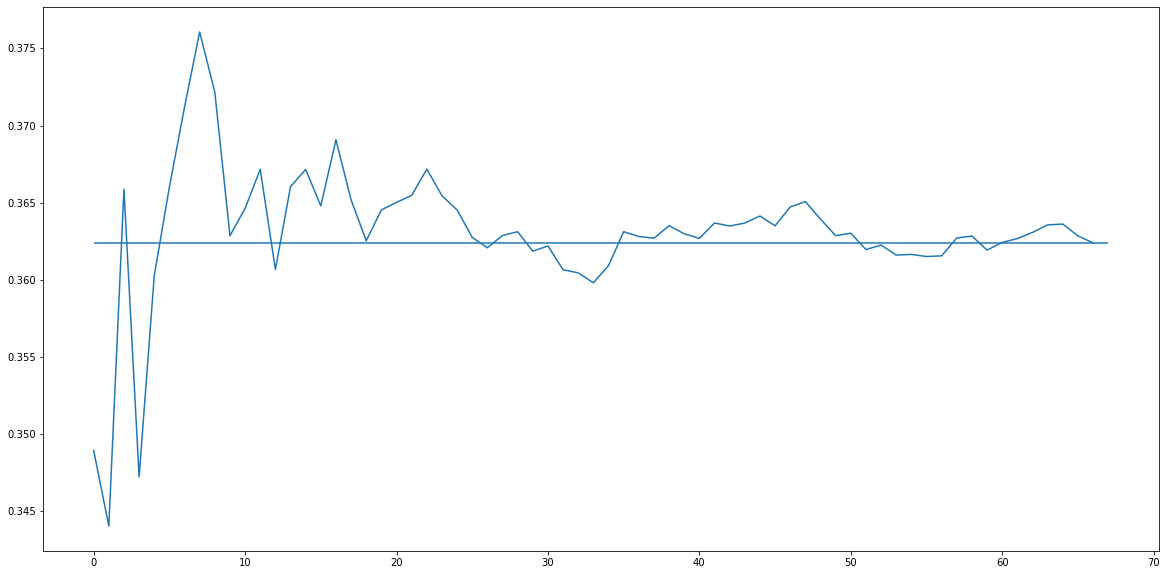

In [9]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(sim_arr)), sim_arr)
plt.hlines(sim_sum / img_count, 0, len(sim_arr))

## Grid search 

In [31]:
st_model = SentenceTransformer('../input/sentence-transformers-222/all-MiniLM-L6-v2/')
model, processor = get_model(CFG.model)

val_dataset = CustomDataSet(
    data_dir=train_data_dir, 
    img2prompt=val_prompt_dict, 
)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=CFG.batch_size, 
    shuffle=False ,                   
    num_workers=CFG.num_workers
)

In [ ]:
model_params = {
    "num_return_sequences": [1, 3, 5, 10, 20],
    "num_beams": [1, 3, 5, 10, 20],
    "repetition_penalty": [1., 5., 10., 100.]
}

for param in ParameterGrid(model_params):
    if param["num_return_sequences"] > param["num_beams"]:
        continue
        
    sim_sum = 0
    img_count = 0
    for i, (img_name_arr, img_arr, true_prompts) in enumerate(bar := tqdm(val_dataloader)):   
        pixel_values = processor(images=img_arr, return_tensors="pt")["pixel_values"].to(CFG.device)
        model_out = model.generate(
            pixel_values=pixel_values,
            max_length=CFG.max_length, min_length=CFG.min_length, 
            **param
        )
        prompts = processor.batch_decode(model_out, skip_special_tokens=True)

        prompts_emb = st_model.encode(prompts)
        true_prompts_emb = st_model.encode(true_prompts)

        for i in range(len(img_name_arr)):
            pred_prompt_embs = prompts_emb[i*CFG.num_return_sequences:(i+1)*CFG.num_return_sequences]
            pred_prompt = pred_prompt_embs.mean(axis=0)
            true_prompt = true_prompts_emb[i]
            
            sim_sum += get_sim(pred_prompt, true_prompt)
            img_count += 1

        bar.set_description(f"Sim: {sim_sum / img_count}")

    sim_mean = sim_sum / img_count
    print(sim_mean, param)

## Inference 

In [5]:
st_model = SentenceTransformer('../input/sentence-transformers-222/all-MiniLM-L6-v2/')
model, processor = get_model(CFG.model)

test_data_dir = Path("../input/stable-diffusion-image-to-prompts/images/")
test_image_names = sorted(os.listdir(test_data_dir))
test_prompt_dict = {img_name: "" for img_name in test_image_names}

test_dataset = CustomDataSet(   
    data_dir=test_data_dir, 
    img2prompt=test_prompt_dict, 
)
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=CFG.batch_size, 
    shuffle=False, 
    num_workers=CFG.num_workers
)

In [6]:
pred_arr = []
for img_name_arr, img_arr, true_prompts in tqdm(test_dataloader):  
    pixel_values = processor(images=img_arr, return_tensors="pt")["pixel_values"].to(CFG.device)
    model_out = model.generate(
        pixel_values=pixel_values,
        max_length=CFG.max_length, min_length=CFG.min_length, 
        num_return_sequences=CFG.num_return_sequences, num_beams=CFG.num_beams, 
        repetition_penalty=CFG.repetition_penalty
    )
    prompts = processor.batch_decode(model_out, skip_special_tokens=True)
    prompts_emb = st_model.encode(prompts)
    
    
    for i in range(len(img_name_arr)):
        pred_prompt_embs = prompts_emb[i*CFG.num_return_sequences:(i+1)*CFG.num_return_sequences]
        pred_prompt = pred_prompt_embs.mean(axis=0)
        
        pred_arr.append(pred_prompt)

pred_arr = np.array(pred_arr)
pred_arr.shape

  0%|          | 0/1 [00:00<?, ?it/s]

(7, 384)

In [7]:
prompts

['this is an aerial view of a circular hole in the ground',
 'this is an aerial view of a circular hole in the sand',
 'this is an aerial view of a circular hole in the desert',
 'this is an aerial view of a circular hole in the sky',
 'this is an aerial view of a circular hole in the middle of some sand',
 'there is a wooden plate that has some sort of design on it',
 'there is a wooden plate that has some kind of design on it',
 'there is a wooden plate that has some sort of art on it',
 'there is a wooden plate that has some type of art on it',
 'there is a wooden plate that has some sort of swirl on it',
 'there is a cartoon dinosaur eating some food in the woods',
 'there is a cartoon dinosaur eating some cheese in the woods',
 'there is a cartoon dinosaur eating some food in the forest',
 'there is a cartoon dinosaur eating cheese in the woods',
 'there is a cartoon dinosaur eating some cheese in the forest',
 'there is a drawing of a robot holding a hammer in one hand and anothe

In [20]:
submission = create_submission(pred_arr, test_image_names)
submission

,val
imgId_eId,
20057f34d_0,0.062122
20057f34d_1,0.110533
20057f34d_2,0.028227
20057f34d_3,0.043295
20057f34d_4,-0.036729
...,...
f27825b2c_379,0.023771
f27825b2c_380,0.000677
f27825b2c_381,-0.107496


In [ ]:
if CFG.is_kaggle:
    submission.to_csv("submission.csv")